# Projet 2 : Analyse des données de systèmes éducatifs

## 0. Importations des modules et des données

In [352]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline
#% matplotlib notebook
# graphes interactifs
import re
#import scipy.stats as st
#import statsmodels.api as sm
#from sklearn.datasets import load_iris
#iris_df_ori = load_iris()

####     A ESSAYER      #######################################################
# GRAPHES INTERACTIFS


# POUR LES GRAPHIQUES
# % matplotlib inline 
# plt.rcParams['figure.figsize'] = [9.5, 6] # ajuster la taille

# POUR DESACTIVER LA TOOLBOX GRAPHES TOP GRANDS
# %%javascript
# IPython.OutputArea.prototype._should_scroll = function(lines) {
#     return false;
# }


L'ensemble des données téléchargées se compose de 5 fichiers .csv et d'un fichier excel comportant 5 onglets.
Il semble que l'intégralité des données des fichiers .csv soit reprise dans chacun des onglets du fichier Excel.

Dans ce notebook, on appellera "base de donnée" l'ensemble des données, et "table" chacun des onglets ou fichier .csv correspondant.

In [105]:
# Utilisé la fonction dropna (colonne nulle) pour éliminer les colonnes fantômes "Unamed en fin de tableau"
data = pd.read_csv("../DONNEES/EdStatsData.csv").dropna(how='all', axis='columns')
country = pd.read_csv("../DONNEES/EdStatsCountry.csv").dropna(how='all', axis='columns')
cnt_ser = pd.read_csv("../DONNEES/EdStatsCountry-Series.csv").dropna(how='all', axis='columns')
series = pd.read_csv("../DONNEES/EdStatsSeries.csv").dropna(how='all', axis='columns')
footnote = pd.read_csv("../DONNEES/EdStatsFootNote.csv").dropna(how='all', axis='columns')

## 1. Description globale des 5 tables

In [106]:
## Fonction qui extrait les données principales relatives aux colonnes

def infos_df (df):
    infos = pd.DataFrame(df.dtypes).T.rename(index={0:'Type'}) 
    infos = infos.append(pd.DataFrame([df[col].size for col in df.columns],index=df.columns)\
                               .T.rename(index={0:'Nbe lignes'}))
    infos = infos.append(pd.DataFrame(df.isna().sum()).T.rename(index={0:'Nbe NaN'}))
    infos = infos.append(pd.DataFrame(infos.loc["Nbe lignes"]-infos.loc["Nbe NaN"])\
                         .T.rename(index = {0:"Nbe Entrées"}))
    infos = infos.append(pd.DataFrame(df.isna().sum()/df.shape[0]*100).T.rename(index={0:'% NaN'}))
    infos = infos.append(pd.DataFrame([df[col].unique().size for col in df.columns],index=df.columns)\
                               .T.rename(index={0:'Nbe uniques'}))
    return infos

In [107]:
###############
#     Data    #
###############
infos_df(data)

,Country Name,Country Code,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,1975,...,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
Type,object,object,object,object,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
Nbe lignes,886930,886930,886930,886930,886930,886930,886930,886930,886930,886930,...,886930,886930,886930,886930,886930,886930,886930,886930,886930,886930
Nbe NaN,0,0,0,0,814642,851393,851311,851385,851200,799624,...,835494,835494,835494,835494,835494,835494,835494,835494,835494,835494
Nbe Entrées,886930,886930,886930,886930,72288,35537,35619,35545,35730,87306,...,51436,51436,51436,51436,51436,51436,51436,51436,51436,51436
% NaN,0,0,0,0,91.8496,95.9933,95.984,95.9924,95.9715,90.1564,...,94.2007,94.2007,94.2007,94.2007,94.2007,94.2007,94.2007,94.2007,94.2007,94.2007
Nbe uniques,242,242,3665,3665,24596,30893,30983,30989,31140,37839,...,8028,7915,7801,7701,7563,7467,7336,7151,7045,6915


In [108]:
###############
#   Country   #
###############
infos_df(country)

,Country Code,Short Name,Table Name,Long Name,2-alpha code,Currency Unit,Special Notes,Region,Income Group,WB-2 code,...,Government Accounting concept,IMF data dissemination standard,Latest population census,Latest household survey,Source of most recent Income and expenditure data,Vital registration complete,Latest agricultural census,Latest industrial data,Latest trade data,Latest water withdrawal data
Type,object,object,object,object,object,object,object,object,object,object,...,object,object,object,object,object,object,object,float64,float64,object
Nbe lignes,241,241,241,241,241,241,241,241,241,241,...,241,241,241,241,241,241,241,241,241,241
Nbe NaN,0,0,0,0,3,26,96,27,27,1,...,80,60,28,100,81,130,99,134,56,62
Nbe Entrées,241,241,241,241,238,215,145,214,214,240,...,161,181,213,141,160,111,142,107,185,179
% NaN,0,0,0,0,1.24481,10.7884,39.834,11.2033,11.2033,0.414938,...,33.195,24.8963,11.6183,41.4938,33.61,53.9419,41.0788,55.6017,23.2365,25.7261
Nbe uniques,241,241,241,241,239,153,132,8,6,241,...,3,3,28,61,76,3,36,12,14,21


In [109]:
#################
#     Series    #
#################
infos_df(series)

,Series Code,Topic,Indicator Name,Short definition,Long definition,Periodicity,Base Period,Other notes,Aggregation method,Limitations and exceptions,General comments,Source,Statistical concept and methodology,Development relevance,Related source links
Type,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
Nbe lignes,3665,3665,3665,3665,3665,3665,3665,3665,3665,3665,3665,3665,3665,3665,3665
Nbe NaN,0,0,0,1509,0,3566,3351,3113,3618,3651,3651,0,3642,3662,3450
Nbe Entrées,3665,3665,3665,2156,3665,99,314,552,47,14,14,3665,23,3,215
% NaN,0,0,0,41.1733,0,97.2988,91.4325,84.9386,98.7176,99.618,99.618,0,99.3724,99.9181,94.1337
Nbe uniques,3665,37,3665,1170,2060,2,5,15,4,10,9,31,3,2,2


In [110]:
#########################
#     Country-Series    #
#########################
infos_df(cnt_ser)

,CountryCode,SeriesCode,DESCRIPTION
Type,object,object,object
Nbe lignes,613,613,613
Nbe NaN,0,0,0
Nbe Entrées,613,613,613
% NaN,0,0,0
Nbe uniques,211,21,97


In [111]:
#################
#    FootNote   #
#################
infos_df(footnote)

,CountryCode,SeriesCode,Year,DESCRIPTION
Type,object,object,object,object
Nbe lignes,643638,643638,643638,643638
Nbe NaN,0,0,0,0
Nbe Entrées,643638,643638,643638,643638
% NaN,0,0,0,0
Nbe uniques,239,1558,56,9102


## 2. Vérification de la qualité des données
### 2.1 Données dupliquées ou contradictoires
#### Noms et codes des pays

- Les tables "Data" et "Country" n'ont pas le même nombre d'entrée uniques pour la colonne "Country Code" : la table "Country" contient un pays en moins. On cherche à déterminer ce pays :

In [112]:
# Fonction qui trouve les éléments différents dans deux tableaux (réciproque)

def Diff(tab1, tab2):  # le nombre total de différences
    tab_dif = [i for i in tab1 + tab2 if i not in tab1 or i not in tab2] 
    return tab_dif 

def Diff_bis(tab1, tab2): # compare en détaillant les entrées différentes de tab1, puis de tab2
    tab_dif = [i for i in tab1 + tab2 if i not in tab1 or i not in tab2] 
    return (set(tab1)-set(tab2),set(tab2)-set(tab1))

In [113]:
pays = Diff(list(data["Country Code"].unique()),list(country["Country Code"].unique()))
print("Code et nom du pays manquant dans Country : {},{}"\
  .format(pays,[data["Country Name"][data["Country Code"]==pays[i]].iloc[0] for i in range(len(pays))]))

Code et nom du pays manquant dans Country : ['VGB'],['British Virgin Islands']


- On souhaite ensuie tester la correspondance bijective entre plusieurs paires de colonnes d'une même table afin de pouvoir répondre à des questions du type :

> __Une entrée de 'nom_col1' correspond-elle à une et une seule entrée de la colonne 'nom_col2' dans la table 'df' ?__

On crée une fonction pour cela :

In [114]:
# Fonction comparant la correspondance unique entre les valeurs d'une même ligne de deux colonnes d'une base
# (bijection entre les valeurs de col1 et de col2)

def Adeq (df, nom_col1,nom_col2):
    mon_zip = zip(df[nom_col1], df[nom_col2]) # associe les entrées des deux colonnes en tuples
    nbe_comb = len(set(mon_zip)) # retourne les valeurs uniques des tuples
    return nbe_comb==df[nom_col1].unique().size # si le nbe est le même que les valeurs uniques, c'est bon

# Version très lourde de la même fonction
# def Adeq_Col(df, nom_col1,nom_col2): # dans une même base df
#     tab = []
#     for i in range(len(df[nom_col1].unique())):
#         uni_i = df[nom_col1].unique()[i]
#         # liste des valeurs de col2 correspondant à la ième valeur unique de col1
#         li = df[df[nom_col1]==uni_i][nom_col2]
#         temp = 0
#         for j in range(len(li)): # comparaison de toutes les valeurs de li une à une
#             if li.iloc[j] != li.iloc[0]: # on prend la première valeur (0) comme référence
#                 temp+=1
#         tab.append(temp)
#     return temp # la valeur retournée est le nombre de valeurs différentes

Puis on teste les couples de colonnes listés ci-dessous :
- Table "Data" : "Country Code", "Country Name"
- Table "Data" : "Indicator Code", "Indicator Name"
- Table "Country" : "Country Code", "Short Name"
- Table "Country" : "Country Code", "Table Name"
- Table "Country" : "Country Code", "Long Name"
- Table "Series" : "Series Code", "Indicator Name"

In [115]:
print("Data : {} {}"\
      .format(Adeq(data, "Country Code", "Country Name"), Adeq(data, "Indicator Code", "Indicator Name")))
print("Country : {} {} {}"\
      .format(Adeq(country, "Country Code", "Short Name"), Adeq(country, "Country Code", "Table Name"),\
        Adeq(country, "Country Code", "Long Name")))
print("Series : {}".format(Adeq(series, "Series Code", "Indicator Name")))

Data : True True
Country : True True True
Series : True


In [116]:
a = [3,2,1,5,1,6,1]
b = ['c','b','a','e','a','u','a']
z = zip(a,b)
set(z)

{(1, 'a'), (2, 'b'), (3, 'c'), (5, 'e'), (6, 'u')}

Y a-t-il la même correspondance entre les codes pays ("Country Code") et les noms de pays dans les tables "Data" ("Country Name") et "Country" ("Table Name") ?
Si oui, on ne gardera qu'une des deux colonnes.

In [148]:
#set(zip(sorted(data["Country Name"].unique()), sorted(country["Table Name"].unique())))
data_gb_cnt = data.groupby("Country Code").count() #"Country Name"

##### Noms et codes des indicateurs statistiques

In [ ]:
Il est

On remarque que malgré les noms différents, les colonnes "Indicator Code" de la table "Data" et "Series Code" de la table "Series" semblent faire référence au même code d'indicateur statistique, et ont, elles aussi, le même nombre d'entrées uniques de 3665.
Regardons si les entrées uniques de ces deux colonnes correspondent :

In [ ]:
code = Diff_bis(list(data["Indicator Code"].unique()),list(series["Series Code"].unique()))
len(code[0]),len(code[1])

53 entrées uniques de la colonne "Indicator Code" de la table "Data" ne sont pas dans la table "Series" et que le même nombre 53 d'entrées uniques de la colonne "Series Code" ne sont pas dans la table "Data".

In [ ]:
list(code[0])[:2], list(code[1])[:2]

On constate que tous les codes différents de la colonne "Series Code" (table "Series") ont certaines lettres en minuscule.
Essayons donc de mettre toutes les entrées en majuscule et de refaire la comparaison.

In [ ]:
# pour la table "Series"
test_series = pd.Series([series["Series Code"][i].upper() for i in range(series["Series Code"].index.size)],\
                 index = series["Series Code"].index)
# pour la table "Data"
test_data = pd.Series([data["Indicator Code"][i].upper() for i in range(data["Indicator Code"].index.size)],\
                 index = data["Indicator Code"].index)

code = Diff_bis(list(test_data.unique()),list(test_series.unique()))
len(code[0]),len(code[1])

In [ ]:
list(code[0]), list(code[1])

La liste ci-dessus montre qu'il faudra également retirer les espaces de la colonne "Series Code" de la table "Series".

In [ ]:
test_series = pd.Series([test_series.iloc[i].replace(" ", "") for i in range(test_series.index.size)],\
                 index = series["Series Code"].index)

In [ ]:
code = Diff_bis(list(test_data.unique()),list(test_series.unique()))
len(code[0]),len(code[1])

On remarque par ailleurs que les colonnes "Indicator Name" des tables "Data" et "Series" ont le même nombre d'entrées uniques (3665). Vérifions si ces entrées uniques correspondent :

In [ ]:
indic = Diff_bis(list(data["Indicator Name"].unique()),list(series["Indicator Name"].unique()))
len(indic[0]), len(indic[1])

On remarque que 462 entrées uniques de la colonne "Indicator Name" de la table "data" ne sont pas dans la table "series" et que le même nombre 462 d'entrées uniques de la même colonne de la table "series" ne sont pas dans la table "data".

Cela pourrait-il indiquer qu'il s'agirait des mêmes entrées qui ne présentent que de petites variations d'écriture, comme c'est le cas pour les deux entrées ci-dessous ?

In [ ]:
indic = Diff_bis(list(data["Indicator Code"].unique()),list(series["Series Code"].unique()))
len(indic[0]), len(indic[1])

In [ ]:
list(indic[0])[7],list(indic[1])[8]

In [ ]:
a = data["Indicator Code"][data["Indicator Name"]=='SABER: (School Autonomy Accountability) Policy Goal 2: Level of autonomy in personnel management'].iloc[0:3]
b = series["Series Code"][series["Indicator Name"]=='SABER: (School Autonomy and Accountability) Policy Goal 2: Level of autonomy in personnel management']
a,b

#### Colonnes de la table "CountrySeries" et "FootNote"

Les entrées des colonnes "CountryCode" et "SeriesCode" des tables "CountrySeries" et "FootNote" existent-ils dans la liste de référence "Country Code" de la table "Data" ?

Les années de la table "FootNote" sont-elles dans les années correspondant aux noms de colonnes de la table "Data" ?

In [ ]:
# liste des années de la colonne "Year" de la table "FootNote"
#set(footnote["Year"].unique())
footnote[footnote["Year"]=='yr2012']

## Exploration de la table "Data"

Les indicateurs qui nous intéressent sont ceux des dernières années.
On cherche les pays qui ont plus de 10 indicateurs disponibles pour l'année 2017 

In [317]:
# Tableau des nombres d'indicateurs dispo pour chaque pays et chaque année 
nb_ind_cnt = data.groupby(['Country Name', 'Country Code']).count()

In [329]:
# Pays ayant un nbe d'indicateur non nul en 2017
nb_ind_cnt[nb_ind_cnt['2017']!=0]

,,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,1975,1976,1977,...,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
Country Name,Country Code,,,,,,,,,,,,,,,,,,,,,
Afghanistan,AFG,3665,3665,523,139,158,236,351,537,164,318,...,0,0,0,0,0,0,0,0,0,0
Bangladesh,BGD,3665,3665,477,71,93,154,107,437,233,192,...,308,308,308,308,308,308,308,308,308,308
Fiji,FJI,3665,3665,498,116,195,196,200,526,162,183,...,0,0,0,0,0,0,0,0,0,0
Liberia,LBR,3665,3665,516,149,150,71,69,511,136,56,...,308,308,308,308,308,308,308,308,308,308
Sierra Leone,SLE,3665,3665,416,222,213,207,219,518,149,130,...,308,308,308,308,308,308,308,308,308,308
Tajikistan,TJK,3665,3665,409,49,50,50,50,410,50,50,...,308,308,308,308,308,308,308,308,308,308
Ukraine,UKR,3665,3665,416,109,102,100,97,415,107,107,...,308,308,308,308,308,308,308,308,308,308


array([[ 0, -1, -2, -3, -4],
       [ 1,  0, -1, -2, -3],
       [ 2,  1,  0, -1, -2]])

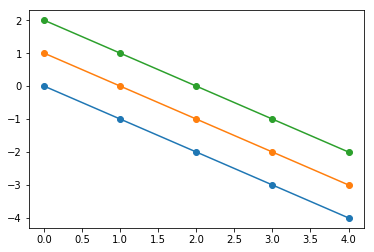

In [431]:
colors = ['#9170c7', '#7aa444', '#cb547b', '#4cab98', '#c5793e', '#ADCF4F']
plt.plot(range(5), [np.arange(3)-i for i in range(5)], '-o')
#['#9170c7', '#7aa444', '#cb547b', '#4cab98', '#c5793e']
#color = ['b', 'r', 'k', 'g' , 'p', 'y']
np.array([np.arange(3)-i for i in range(5)]).T

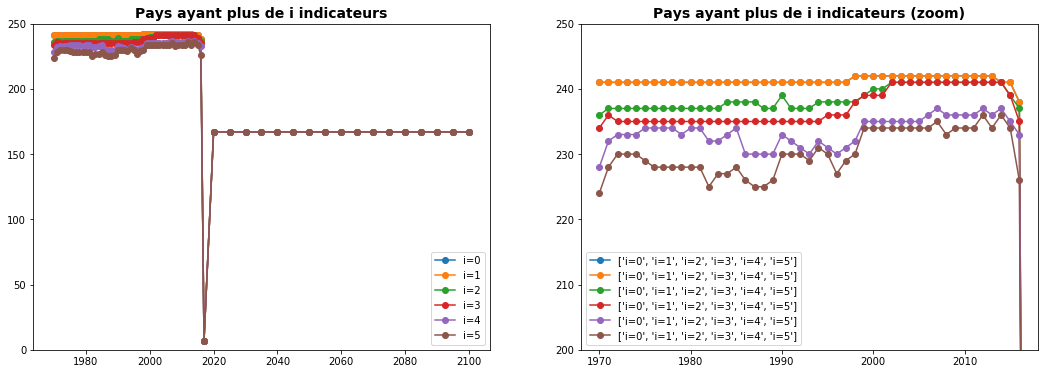

In [441]:
# Nbe de pays ayant un indicateur non nul en fonction des années
countrys = [nb_ind_cnt.index[i][0] + " - " + nb_ind_cnt.index[i][1] for i in range(nb_ind_cnt.index.size)]
years = list(range(1970,2018))+list(range(2020,2105,5))
nb_pay_rens0 = [nb_ind_cnt[nb_ind_cnt[str(i)]!=0].index.size for i in years]
nb_pay_rens1 = [nb_ind_cnt[nb_ind_cnt[str(i)]>0].index.size for i in years]
nb_pay_rens2 = [nb_ind_cnt[nb_ind_cnt[str(i)]>2].index.size for i in years]
nb_pay_rens5 = [nb_ind_cnt[nb_ind_cnt[str(i)]>5].index.size for i in years]
nb_pay_rens10 = [nb_ind_cnt[nb_ind_cnt[str(i)]>10].index.size for i in years]
nb_pay_rens15 = [nb_ind_cnt[nb_ind_cnt[str(i)]>15].index.size for i in years]
nb_pay_rens = np.array([nb_pay_rens0, nb_pay_rens1, nb_pay_rens2, nb_pay_rens5, nb_pay_rens10, nb_pay_rens15])

fig = plt.figure(figsize = (18,6))
plot1 = plt.subplot(1,2,1)
[plot1.plot(years, nb_pay_rens[i], '-o', label = "i="+str(i)) for i in range(6)]
plot1.set_ylim(0,250)
plot1.legend(loc = 'lower right')
plot1.set_title("Pays ayant plus de i indicateurs", fontsize = 14, fontweight = 'bold')
plot2 = plt.subplot(1,2,2)
plot2.plot(years, nb_pay_rens.T, '-o', label = ["i="+str(i) for i in range(6)])
plot2.set_xlim(1968,2018)
plot2.set_ylim(200,250)
plot2.legend(loc = 'lower left')
plot2.set_title("Pays ayant plus de i indicateurs (zoom)", fontsize = 14, fontweight = 'bold')
plt.show() 

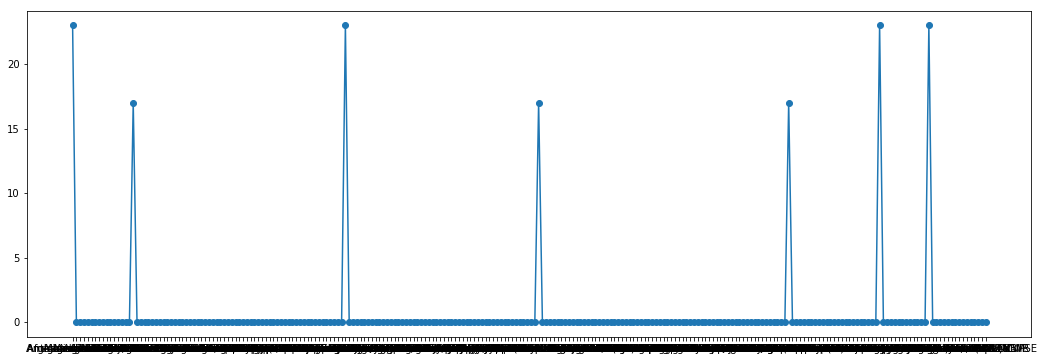

In [315]:
# Classement des pays en fonction du nombre d'indicateurs disponibles en 2017
fig = plt.figure(figsize = (18,6))
x = countrys
y = nb_ind_cnt['2017']
plt.plot(x, y, '-o')
plt.
plt.show() 

In [293]:
arrays = [[1, 1, 2, 2], ['red', 'blue', 'red', 'blue']]
pd.MultiIndex.from_arrays(arrays, names=('number', 'color'))
# MultiIndex(levels=[[1, 2], ['blue', 'red']],
#            codes=[[0, 0, 1, 1], [1, 0, 1, 0]],
#            names=['number', 'color'])

MultiIndex(levels=[[1, 2], ['blue', 'red']],
           labels=[[0, 0, 1, 1], [1, 0, 1, 0]],
           names=['number', 'color'])

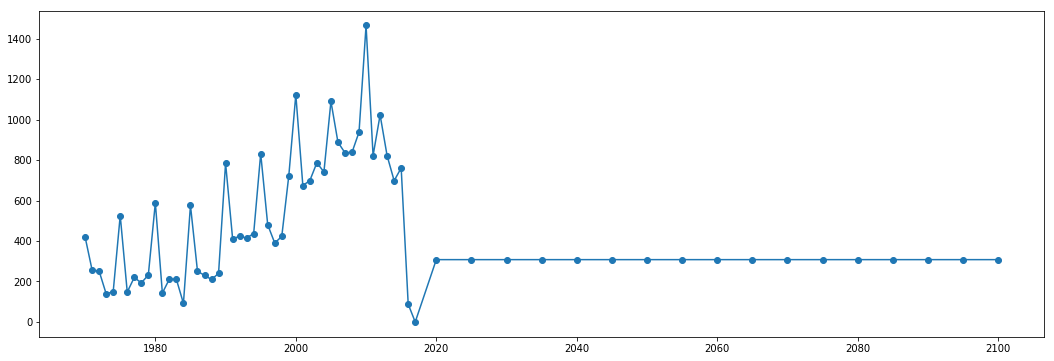

In [260]:
# Nbe d'indicateurs (sur 3665 = max) dispo par année pour un pays

tab = [data_gb_cnt[data_gb_cnt.index=='FRA'][year].values for year in data_gb_cnt.columns[3:].values]
fig = plt.figure(figsize = (18,6))
x = years
y = tab
plt.plot(x, y, '-o')
plt.show() 

## -------------- BROUILLONS -------------

In [ ]:
tab1 = list(['a', 'b', 'c', 'd', 'e'])
tab2 = list(['adfc', 'c', 'd', 'e'])

list1 = [10, 15, 20, 45, 30, 35, 25]
list2 = [25, 40, 35] 


def Diff(tab1, tab2): 
    tab_dif = [i for i in tab1 + tab2 if i not in tab1 or i not in tab2] 
    return tab_dif 

Diff(list1, list2)
(set(tab2)-set(tab1)),(set(tab1)-set(tab2))


In [264]:
## .str.match (s'applique à un index)

df = pd.DataFrame([0,1,2,3,4], index = ['a', 'b', 'Unnamed', 'd', 'e'])
df = df.T
~df.columns.str.match('Unnamed')
df.loc[:, [True, False, True]]

,a,Unnamed
0,0,2


In [ ]:
## groupby, merge, join, concat etc.

#DataFrame.merge(right, how='inner', on=None, left_on=None, right_on=None, left_index=False,
# right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None)
df1 = pd.DataFrame({'lkey': ['foo', 'bar', 'baz', 'foo'], 'value': [1, 2, 3, 1], 'value2': [100, 200, 300, 500]})
df2 = pd.DataFrame({'rkey': ['foo', 'bar', 'baz', 'foo'], 'value': [5, 6, 7, 8]})
#df1.merge(df2, right_on='rkey')
df1.merge(df2, left_on = 'lkey', right_on='rkey')
df1.groupby(['value', 'lkey']).count()